In [1]:
!pip install -q -U keras-tuner

In [2]:
from tensorflow import keras
# from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


In [5]:
# set seed

from numpy.random import seed
from tensorflow.random import set_seed as tf_set_seed

seedvalue = 13


def setRandomSeed(seedvalue):
  seed(seedvalue)
  tf_set_seed(seedvalue)
  return

setRandomSeed(seedvalue)

# Load Data, Preprocessing and reshape

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# Preprocess the data
print(X_train.shape)  # Output: (60000, 28, 28)
print(y_train.shape)  # Output: (60000,)

# Normalise the data
X_train = X_train.astype('float32') /255.0
X_test = X_test.astype('float32') /255.0

# Reshape the input data to have a single channel
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
print("\nAfter reshaping:")
print(f"{X_train.shape = }")
print(f"{X_test.shape = }")
print("\nX_train.max() should be 1 after normalise, X_train.max() = ",X_train.max())
print("]n Unique labels in y_train:", np.unique(y_train))

(60000, 28, 28)
(60000,)

After reshaping:
X_train.shape = (60000, 28, 28, 1)
X_test.shape = (10000, 28, 28, 1)

X_train.max() should be 1 after normalise, X_train.max() =  1.0
]n Unique labels in y_train: [0 1 2 3 4 5 6 7 8 9]


# Preview images

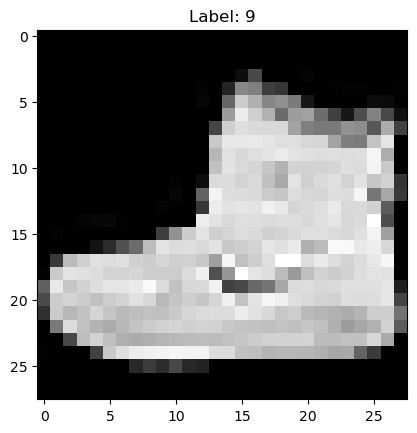

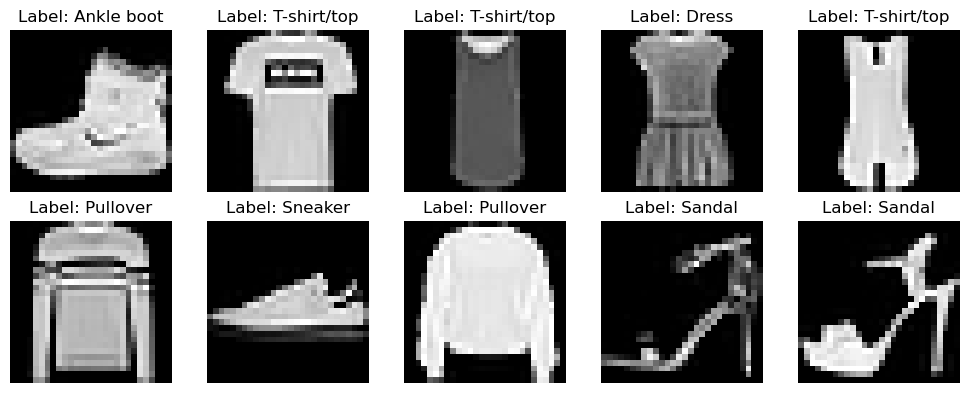

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Display a single image
plt.imshow(X_train[0], cmap='gray')
plt.title('Label: ' + str(y_train[0]))
plt.show()

# Display multiple images in a grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title('Label: ' + (class_names[y_train[i]]))

    ax.axis('off')
plt.tight_layout()
plt.show()

# CNN

In [35]:
# function

def model_result(model, model_history, X_test, y_test, title):
  print(f"\n{title} Model Evaluation:")
  loss, acc = model.evaluate(X_test, y_test, verbose = 0)
  print(f"Test accuracy: {acc}")
  print(f"Test loss: {loss}")

  fig = plt.figure()
  plt.plot(model_history.history['accuracy'], label='Training Accuracy')
  plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
  plt.title(f'{title} Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(0.8,1.0)
  plt.legend()
  plt.show()

In [47]:
# Function
def display_matrix(model, X_test, y_test, label, title):
  y_pred = model.predict(X_test, verbose = 0).argmax(axis=1)
  print(f"{title}")
  print("Classification Report:")
  print(classification_report(y_test, y_pred, target_names=label))

  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=label)
  disp.plot()
  plt.title(f"{title} Confusion Matrix")
  plt.xticks(rotation = 90)
  plt.show()

In [10]:
# create a ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint('deeper_dropout_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
# create an EarlyStopping callback to stop training when validation accuracy stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True, verbose = 0)

## Basic model

In [12]:
# Basic model: Model 1
model1 = Sequential()
model1.add(Conv2D(64, (3,3), padding = "same", activation = "relu", input_shape=(28, 28, 1)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(128, (3,3), padding = "same", activation = "relu"))
model1.add(Conv2D(128, (3,3), padding = "same", activation = "relu"))
model1.add(Conv2D(256, (3,3), padding = "same", activation = "relu"))
model1.add(Conv2D(256, (3,3), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Flatten())
model1.add(Dense(96, activation = "relu"))
model1.add(Dense(32, activation = "relu"))
model1.add(Dense(10, activation='softmax'))

model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model1_history = model1.fit(X_train, y_train, epochs = 15, batch_size = 10, validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.7797 - loss: 0.6039 - val_accuracy: 0.8729 - val_loss: 0.3429
Epoch 2/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.8896 - loss: 0.2972 - val_accuracy: 0.8864 - val_loss: 0.3169
Epoch 3/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.9095 - loss: 0.2458 - val_accuracy: 0.9012 - val_loss: 0.2825
Epoch 4/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9209 - loss: 0.2145 - val_accuracy: 0.9011 - val_loss: 0.3014
Epoch 5/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9310 - loss: 0.1895 - val_accuracy: 0.8918 - val_loss: 0.3449
Epoch 6/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9367 - loss: 0.1699 - val_accuracy: 0.8995 - val_loss: 0.3431
Epoch 7/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9410 - loss: 0.1600 - val_accuracy: 0.9138 - val_loss: 0.3309
Epoch 8/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.9462 - loss: 0

In [15]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │     1,204,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,945,248 (26.49 MB)

 Trainable params: 2,315,082 (8.83 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,630,166 (17.66 MB)


Model 1: Basic model Model Evaluation:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8940 - loss: 0.3071
Test accuracy: 0.8952000141143799
Test loss: 0.3046082556247711


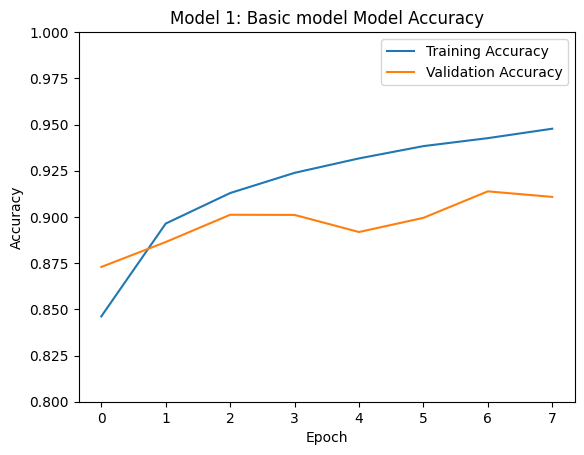

In [25]:
model_result(model1, model1_history, X_test, y_test, "Model 1: Basic model")

Model 1: Basic model
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.87      0.85      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.82      0.83      0.82      1000
       Dress       0.89      0.93      0.91      1000
        Coat       0.77      0.89      0.83      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.81      0.59      0.68      1000
     Sneaker       0.91      0.99      0.95      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.99      0.91      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.89     10000
weighted avg       0.90      0.90      0.89     10000



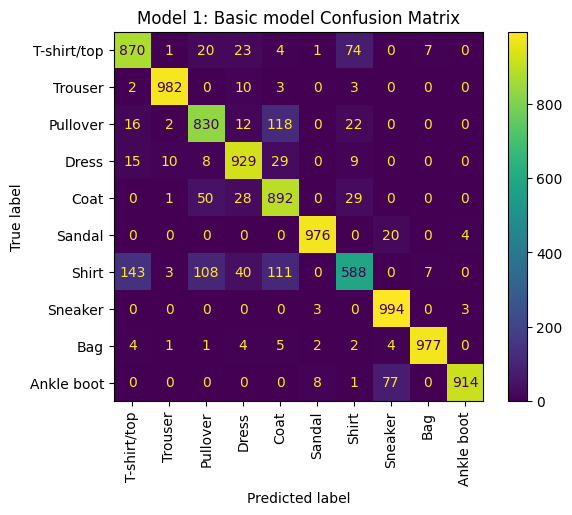

In [48]:
display_matrix(model1, X_test, y_test, class_names, "Model 1: Basic model")

In [87]:
model1.save("model1.keras")

## Overfitting preventation

### Dropout

In [27]:
# Dropout: Model 2
model2 = Sequential()
model2.add(Conv2D(64, (3,3), padding = "same", activation = "relu", input_shape=(28, 28, 1)))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(128, (3,3), padding = "same", activation = "relu"))
model2.add(Conv2D(128, (3,3), padding = "same", activation = "relu"))
model2.add(Dropout(0.2))
model2.add(Conv2D(256, (3,3), padding = "same", activation = "relu"))
model2.add(Conv2D(256, (3,3), padding = "same", activation = "relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Flatten())
model2.add(Dense(96, activation = "relu"))
model2.add(Dense(32, activation = "relu"))
model2.add(Dense(10, activation='softmax'))

model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model2_history = model2.fit(X_train, y_train, epochs = 15, batch_size = 10, validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.7897 - loss: 0.5847 - val_accuracy: 0.8742 - val_loss: 0.3504
Epoch 2/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.8903 - loss: 0.2992 - val_accuracy: 0.8990 - val_loss: 0.2786
Epoch 3/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9067 - loss: 0.2532 - val_accuracy: 0.8970 - val_loss: 0.3179
Epoch 4/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9168 - loss: 0.2227 - val_accuracy: 0.9062 - val_loss: 0.2855
Epoch 5/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9269 - loss: 0.2013 - val_accuracy: 0.9079 - val_loss: 0.2891
Epoch 6/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.9303 - loss: 0.1886 - val_accuracy: 0.9082 - val_loss: 0.3428
Epoch 7/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.9360 - loss: 0.1753 - val_accuracy: 0.9057 - val_loss: 0.3537


In [29]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 96)             │     1,204,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,945,248 (26.49 MB)

 Trainable params: 2,315,082 (8.83 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,630,166 (17.66 MB)


Model 2: Dropout Model Evaluation:
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8886 - loss: 0.3071
Test accuracy: 0.890999972820282
Test loss: 0.3001974821090698


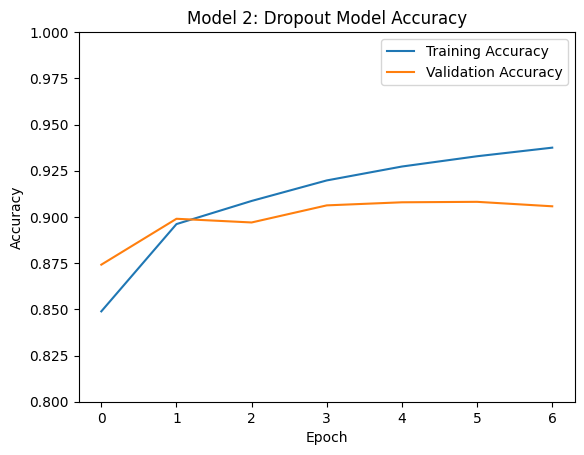

In [30]:
model_result(model2, model2_history, X_test, y_test, "Model 2: Dropout")

Model 2: Dropout
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.86      0.85      1000
     Trouser       0.97      0.99      0.98      1000
    Pullover       0.81      0.87      0.84      1000
       Dress       0.89      0.91      0.90      1000
        Coat       0.83      0.80      0.81      1000
      Sandal       0.99      0.96      0.97      1000
       Shirt       0.73      0.66      0.69      1000
     Sneaker       0.89      0.99      0.94      1000
         Bag       0.99      0.97      0.98      1000
  Ankle boot       0.99      0.90      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



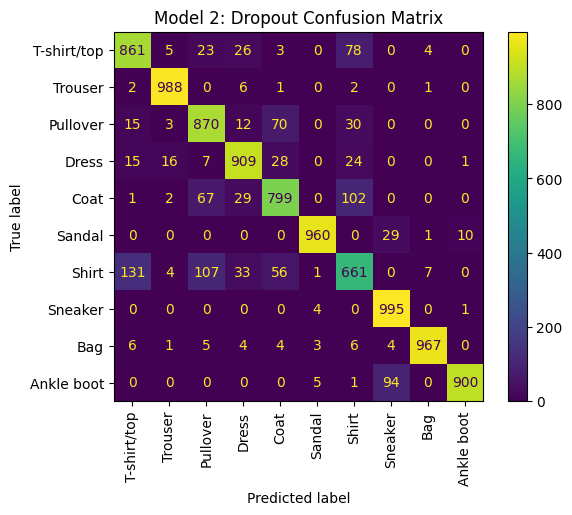

In [49]:
display_matrix(model2, X_test, y_test, class_names, "Model 2: Dropout")

In [88]:
# Save the model
model2.save("model2.keras")

### L2 Regularizer
kernel_regularizer=l2(reg_strength)

In [32]:
# L2 Regularizer: Model 3
model3 = Sequential()
model3.add(Conv2D(64, (3,3), padding = "same", activation = "relu", input_shape=(28, 28, 1), kernel_regularizer= l2(0.02) ))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Conv2D(128, (3,3), padding = "same", activation = "relu", kernel_regularizer= l2(0.02) ))
model3.add(Conv2D(128, (3,3), padding = "same", activation = "relu", kernel_regularizer= l2(0.02) ))
model3.add(Dropout(0.2))
model3.add(Conv2D(256, (3,3), padding = "same", activation = "relu", kernel_regularizer= l2(0.02) ))
model3.add(Conv2D(256, (3,3), padding = "same", activation = "relu", kernel_regularizer= l2(0.02) ))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Flatten())
model3.add(Dense(96, activation = "relu"))
model3.add(Dense(32, activation = "relu"))
model3.add(Dense(10, activation='softmax'))

model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model3_history = model3.fit(X_train, y_train, epochs = 15, batch_size = 10, validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.7276 - loss: 1.0939 - val_accuracy: 0.8234 - val_loss: 0.5589
Epoch 2/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8369 - loss: 0.5212 - val_accuracy: 0.8327 - val_loss: 0.5348
Epoch 3/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8511 - loss: 0.4756 - val_accuracy: 0.8372 - val_loss: 0.5130
Epoch 4/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8607 - loss: 0.4468 - val_accuracy: 0.8522 - val_loss: 0.4829
Epoch 5/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8642 - loss: 0.4299 - val_accuracy: 0.8512 - val_loss: 0.4789
Epoch 6/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8695 - loss: 0.4158 - val_accuracy: 0.8564 - val_loss: 0.4656
Epoch 7/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8759 - loss: 0.4032 - val_accuracy: 0.8588 - val_loss: 0.4565
Epoch 8/15
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8778 - loss: 0


Model 3: L2 Regularizer Model Evaluation:
Test accuracy: 0.8567000031471252
Test loss: 0.4475390613079071


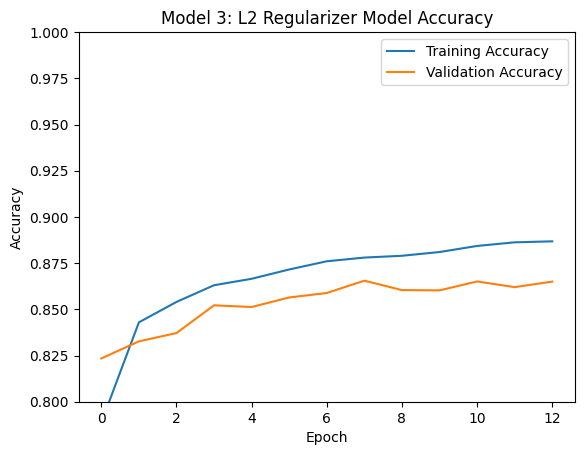

In [36]:
model_result(model3, model3_history, X_test, y_test, "Model 3: L2 Regularizer")

Model 3: L2 Regularizer
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.73      0.88      0.80      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.81      0.76      0.79      1000
       Dress       0.89      0.85      0.87      1000
        Coat       0.73      0.87      0.79      1000
      Sandal       0.99      0.93      0.96      1000
       Shirt       0.70      0.53      0.61      1000
     Sneaker       0.82      0.99      0.90      1000
         Bag       0.98      0.96      0.97      1000
  Ankle boot       0.98      0.84      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



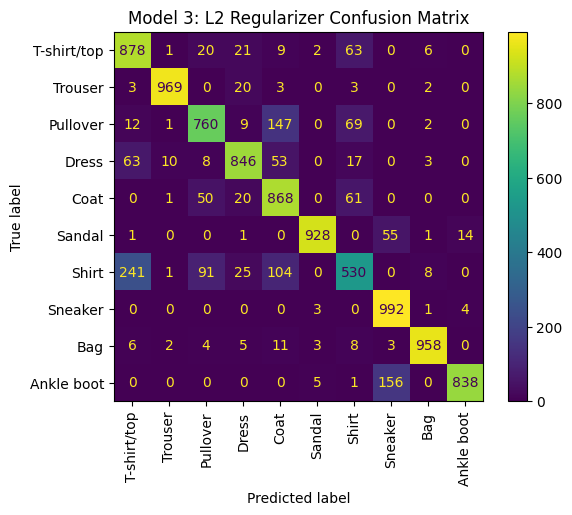

In [50]:
display_matrix(model3, X_test, y_test, class_names, "Model 3: L2 Regularizer")

In [90]:
# Save the model
model3.save("model3.keras")

HyperParameter Tuning

In [54]:
def model_builder(hp):
  model = Sequential()

  hp_layer_1 = hp.Int('layer_1', min_value=32, max_value=256, step=64)
  hp_layer_2 = hp.Int('layer_2', min_value=32, max_value=256, step=64)
  hp_learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01])
  hp_dropout = hp.Choice("dropout", values = [0.0, 0.01, 0.1, 0.5])
  hp_l2 = hp.Choice("l2", values = [0.0, 0.01, 0.08, 0.16, 0.32])


  model.add(Conv2D(64, (3,3), padding = "same", activation = "relu", input_shape=(28, 28, 1), kernel_regularizer= l2(hp_l2)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(128, (3,3), padding = "same", activation = "relu", kernel_regularizer= l2(hp_l2)))
  model.add(Conv2D(128, (3,3), padding = "same", activation = "relu", kernel_regularizer= l2(hp_l2)))
  model.add(Dropout(hp_dropout))
  model.add(Conv2D(256, (3,3), padding = "same", activation = "relu", kernel_regularizer= l2(hp_l2)))
  model.add(Conv2D(256, (3,3), padding = "same", activation = "relu", kernel_regularizer= l2(hp_l2)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(units = hp_layer_1, activation = "relu"))
  model.add(Dense(units = hp_layer_2, activation = "relu"))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model


In [55]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='dir',
                     project_name='x')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Trial 30 Complete [00h 03m 14s]
val_accuracy: 0.793749988079071

Best val_accuracy So Far: 0.8837500214576721
Total elapsed time: 00h 38m 45s


In [91]:
# Retrain the model using the best hyperparameters

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0] # get the top 1st best hyperparameters
model4 = tuner.hypermodel.build(best_hps)
model4_history = model4.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping], verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [98]:
print(best_hps.values)

{'layer_1': 96, 'layer_2': 224, 'learning_rate': 0.001, 'dropout': 0.0, 'l2': 0.01, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


In [92]:
# save the model
model4.save("model4.keras")


Model 4: HyperParameter Tuning Done Model Evaluation:
Test accuracy: 0.878600001335144
Test loss: 0.3982735872268677


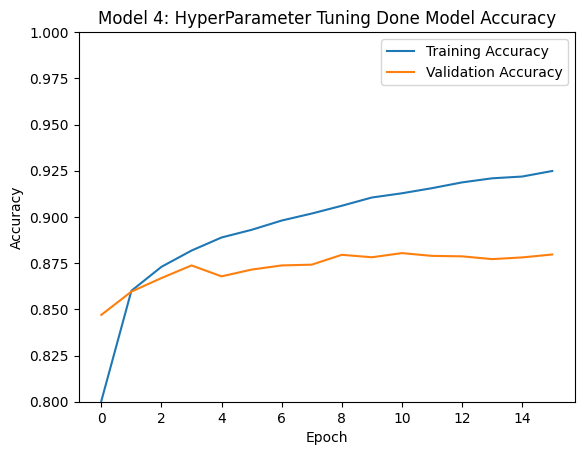

In [93]:
model_result(model4, model4_history, X_test, y_test, "Model 4: HyperParameter Tuning Done")

Model 4: HyperParameter Tuning Done
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.83      0.83      1000
     Trouser       1.00      0.96      0.98      1000
    Pullover       0.89      0.70      0.79      1000
       Dress       0.86      0.93      0.89      1000
        Coat       0.75      0.86      0.80      1000
      Sandal       0.98      0.95      0.96      1000
       Shirt       0.69      0.67      0.68      1000
     Sneaker       0.89      0.98      0.93      1000
         Bag       0.95      0.98      0.97      1000
  Ankle boot       0.99      0.91      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



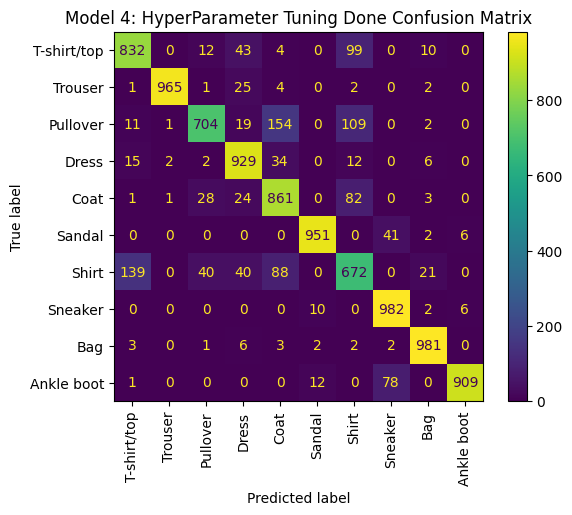

In [94]:
display_matrix(model4, X_test, y_test, class_names, "Model 4: HyperParameter Tuning Done")

In [62]:
model4.save("model4.keras")

# Deploy Model

In [113]:
# load the model
reconstructed_model = keras.models.load_model("model1.keras")

In [103]:
reconstructed_model.evaluate(X_test, y_test, verbose = 0)


Validation accuracy: 0.878600001335144
Validation loss: 0.3982735872268677


Model 1: Basic model
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.87      0.85      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.82      0.83      0.82      1000
       Dress       0.89      0.93      0.91      1000
        Coat       0.77      0.89      0.83      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.81      0.59      0.68      1000
     Sneaker       0.91      0.99      0.95      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.99      0.91      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.89     10000
weighted avg       0.90      0.90      0.89     10000



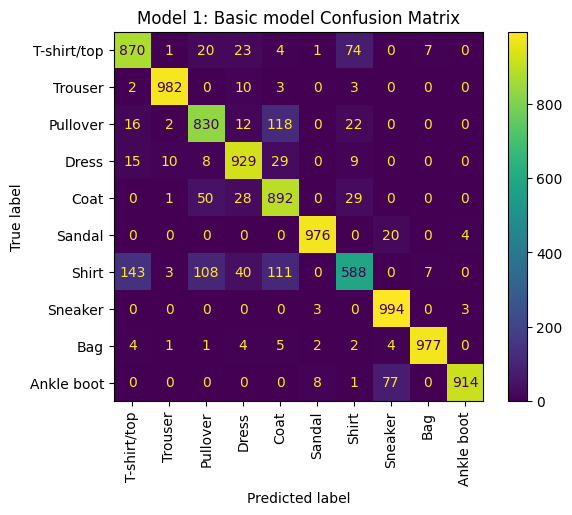

In [114]:
display_matrix(reconstructed_model, X_test, y_test, class_names, "Model 1: Basic model")

In [115]:
!zip -r /content/Folder_To_Zip.zip /content/dir

  adding: content/dir/ (stored 0%)
  adding: content/dir/x/ (stored 0%)
  adding: content/dir/x/trial_0009/ (stored 0%)
  adding: content/dir/x/trial_0009/trial.json (deflated 68%)
  adding: content/dir/x/trial_0009/checkpoint.weights.h5 (deflated 14%)
  adding: content/dir/x/trial_0009/build_config.json (deflated 9%)
  adding: content/dir/x/trial_0017/ (stored 0%)
  adding: content/dir/x/trial_0017/trial.json (deflated 68%)
  adding: content/dir/x/trial_0017/checkpoint.weights.h5 (deflated 52%)
  adding: content/dir/x/trial_0017/build_config.json (deflated 9%)
  adding: content/dir/x/trial_0025/ (stored 0%)
  adding: content/dir/x/trial_0025/trial.json (deflated 68%)
  adding: content/dir/x/trial_0025/checkpoint.weights.h5 (deflated 27%)
  adding: content/dir/x/trial_0025/build_config.json (deflated 9%)
  adding: content/dir/x/trial_0021/ (stored 0%)
  adding: content/dir/x/trial_0021/trial.json (deflated 68%)
  adding: content/dir/x/trial_0021/checkpoint.weights.h5 (deflated 28%)
  a

In [ ]:
/content/dir